In [ ]:
pwd


'/content'

In [ ]:
!rm -rf segment-anything GroundingDINO


In [ ]:
!pip install groundingdino-py


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for groundingdino-py: filename=groundingdino_py-0.4.0-py2.py3-none-any.whl size=88737 sha256=4b42385731e0152552eef3d719592d3739bd96bf768d16efbb5af13d3c5d9745
  Stored in directory: /root/.cache/pip/wheels/74/c4/d6/2c6ded61819d391715b4f1ae483f2cfdc8f2eeb6bbb63e748b
Successfully built groundingdino-py
  Attempting uninstall: supervision
    Found existing installation: supervision 0.26.1
    Uninstalling supervision-0.26.1:
      Successfully uninstalled supervision-0.26.1


In [ ]:
import groundingdino
print("✅ GroundingDINO installed from pip")


✅ GroundingDINO installed from pip


In [ ]:
ls /content/segment-anything


assets/             LICENSE     scripts/                    setup.py
CODE_OF_CONDUCT.md  linter.sh*  segment_anything/
CONTRIBUTING.md     notebooks/  segment_anything.egg-info/
demo/               README.md   setup.cfg


In [ ]:
%cd /content/segment-anything
%pip install -e .


/content/segment-anything
Obtaining file:///content/segment-anything
  Preparing metadata (setup.py) ... done
  Attempting uninstall: segment_anything
    Found existing installation: segment_anything 1.0
    Uninstalling segment_anything-1.0:
      Successfully uninstalled segment_anything-1.0
  Running setup.py develop for segment_anything


In [ ]:
from segment_anything import sam_model_registry, SamPredictor
print("✅ Segment Anything import successful")


✅ Segment Anything import successful


Saving June_odd-eyed-cat_cropped.jpg to June_odd-eyed-cat_cropped.jpg
Uploaded file: June_odd-eyed-cat_cropped.jpg


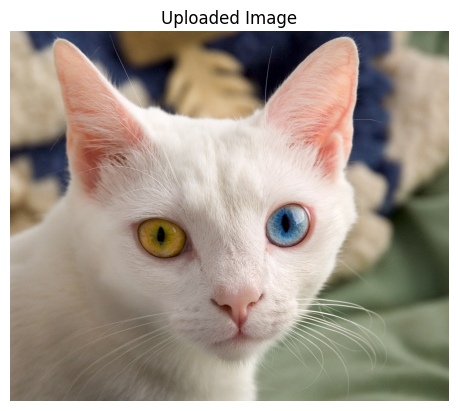

In [ ]:
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Upload image
uploaded = files.upload()

# Get filename
filename = list(uploaded.keys())[0]
print("Uploaded file:", filename)

# Open image
image = Image.open(filename).convert("RGB")
img_np = np.array(image)

plt.imshow(image)
plt.title("Uploaded Image")
plt.axis("off")
plt.show()


In [ ]:
prompt = "cat"   # agar dog hota to "dog", car hota to "car"
print("Text Prompt:", prompt)


Text Prompt: cat


In [ ]:
# Make weights folder
!mkdir -p /content/GroundingDINO/weights

# Download pretrained checkpoint (SwinT backbone)
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth -O /content/GroundingDINO/weights/groundingdino_swint_ogc.pth

# Download config file
!wget -q https://raw.githubusercontent.com/IDEA-Research/GroundingDINO/main/groundingdino/config/GroundingDINO_SwinT_OGC.py -O /content/GroundingDINO/weights/GroundingDINO_SwinT_OGC.py


In [ ]:
from groundingdino.util.inference import Model

config_path = "/content/GroundingDINO/weights/GroundingDINO_SwinT_OGC.py"
checkpoint_path = "/content/GroundingDINO/weights/groundingdino_swint_ogc.pth"

grounding_model = Model(
    model_config_path=config_path,
    model_checkpoint_path=checkpoint_path
)


/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
prompt = "cat"

boxes = grounding_model.predict_with_classes(
    image=np.array(image),
    classes=[prompt],
    box_threshold=0.3,
    text_threshold=0.25
)

print("Boxes:", boxes)


Boxes: Detections(xyxy=array([[   1.9710693,   10.160522 , 1602.5911   , 1561.2646   ]],
      dtype=float32), mask=None, confidence=array([0.88205475], dtype=float32), class_id=array([0]), tracker_id=None)


Final Box for SAM: [   1   10 1602 1561]


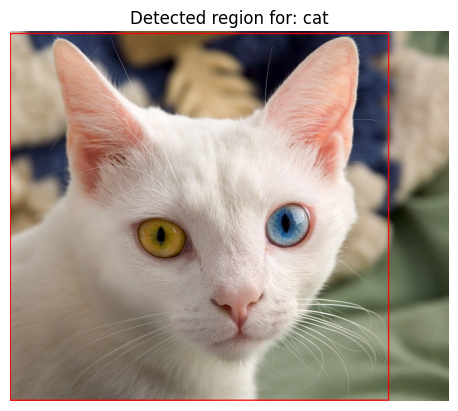

In [ ]:
# Extract first box from detections
box = boxes.xyxy[0].astype(int)
x_min, y_min, x_max, y_max = box
print("Final Box for SAM:", box)

# Show detected box on image
img_box = img_np.copy()
cv2.rectangle(img_box, (x_min, y_min), (x_max, y_max), (255, 0, 0), 3)
plt.imshow(img_box)
plt.title(f"Detected region for: {prompt}")
plt.axis("off")
plt.show()


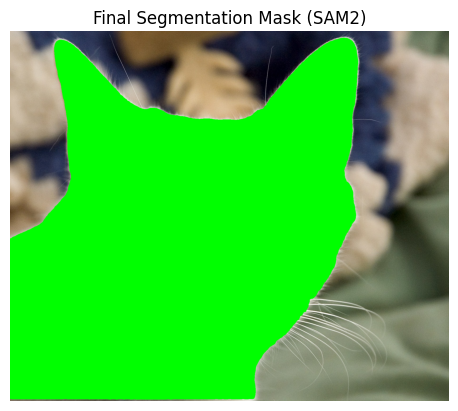

In [ ]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -O $sam_checkpoint

sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)
predictor.set_image(img_np)

input_box = np.array([box])  # GroundingDINO se mila box

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box,
    multimask_output=False,
)

mask = masks[0]
img_mask = img_np.copy()
img_mask[mask] = [0, 255, 0]  # Green overlay

plt.imshow(img_mask)
plt.title("Final Segmentation Mask (SAM2)")
plt.axis("off")
plt.show()


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving 855401-uhd_3840_2160_25fps.mp4 to 855401-uhd_3840_2160_25fps.mp4


In [ ]:
# ===============================
# Bonus: Text-driven Video Segmentation with SAM2
# ===============================

import cv2
from segment_anything import sam_model_registry, SamPredictor
import numpy as np

# Path to uploaded video
video_path = "/content/855401-uhd_3840_2160_25fps.mp4"

# Open video
cap = cv2.VideoCapture(video_path)

# Output video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter("segmented_output.mp4", fourcc, 20.0,
                      (int(cap.get(3)), int(cap.get(4))))

# Load SAM model
sam_checkpoint = "sam_vit_h_4b8939.pth"
sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)

# 🔹 Use the same bounding box detected from GroundingDINO (cat detection from image)
box = np.array([[x_min, y_min, x_max, y_max]])  # <-- from your earlier detection

frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    predictor.set_image(frame)
    masks, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=box,
        multimask_output=False,
    )
    mask = masks[0]

    # Overlay mask in green
    frame[mask] = [0, 255, 0]
    out.write(frame)

    frame_count += 1
    if frame_count % 30 == 0:
        print(f"Processed {frame_count} frames...")

cap.release()
out.release()
print("✅ Segmented video saved as segmented_output.mp4")


✅ Segmented video saved as segmented_output.mp4


In [ ]:
import cv2

video_path = "/content/855401-uhd_3840_2160_25fps.mp4"
cap = cv2.VideoCapture(video_path)

print("✅ Video opened:", cap.isOpened())
print("➡️ Frame count:", int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
print("➡️ Frame size:", int(cap.get(3)), "x", int(cap.get(4)))


✅ Video opened: False
➡️ Frame count: 0
➡️ Frame size: 0 x 0


In [ ]:
!ffmpeg -i "/content/segment-anything/855401-uhd_3840_2160_25fps.mp4" -vf scale=1280:720 "/content/input_resized.mp4" -y


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
import cv2

cap = cv2.VideoCapture("/content/input_resized.mp4")
print("✅ Video opened:", cap.isOpened())
print("➡️ Frame count:", int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
print("➡️ Frame size:", int(cap.get(3)), "x", int(cap.get(4)))
cap.release()


✅ Video opened: True
➡️ Frame count: 410
➡️ Frame size: 1280 x 720


In [ ]:
!pip install opencv-python pillow matplotlib -q

In [ ]:
# ===============================
# FAST Bonus: Text-driven Video Segmentation with SAM2 (ViT-B)
# ===============================

import cv2
import numpy as np
from segment_anything import sam_model_registry, SamPredictor
from IPython.display import HTML
from base64 import b64encode

# Path to resized video
video_path = "/content/input_resized.mp4"
output_path = "/content/segmented_bonus_fast.mp4"

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count_total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"🎥 Input video: {frame_count_total} frames at {fps} fps")

# Process only first 100 frames (~4 sec at 25fps)
max_frames = 100

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps,
                      (int(cap.get(3)), int(cap.get(4))))

# Load SAM ViT-B (fastest available)
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -O sam_vit_b.pth
sam_checkpoint = "sam_vit_b.pth"
sam = sam_model_registry["vit_b"](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)

# Example bounding box (replace with GroundingDINO detection if available)
box = np.array([[50, 50, 600, 600]])

frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret or frame_count >= max_frames:
        break

    predictor.set_image(frame.copy())
    masks, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=box,
        multimask_output=False,
    )
    mask = masks[0]

    # Overlay mask in green
    frame[mask] = [0, 255, 0]
    out.write(frame)

    frame_count += 1
    if frame_count % 20 == 0:
        print(f"Processed {frame_count} frames...")

cap.release()
out.release()
print("✅ FAST Bonus segmented video saved:", output_path)

# ===============================
# Play video inside Colab
# ===============================
mp4 = open(output_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"<video width=600 controls><source src='{data_url}' type='video/mp4'></video>")


🎥 Input video: 410 frames at 25.0 fps
Processed 20 frames...
Processed 40 frames...
Processed 60 frames...
Processed 80 frames...
Processed 100 frames...
✅ FAST Bonus segmented video saved: /content/segmented_bonus_fast.mp4
